# Histogram Specification

In image processing, histogram matching or histogram specification is the transformation of an image so that its histogram matches a specified histogram. The well-known histogram equalization method is a special case in which the specified histogram is uniformly distributed

In [1]:
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

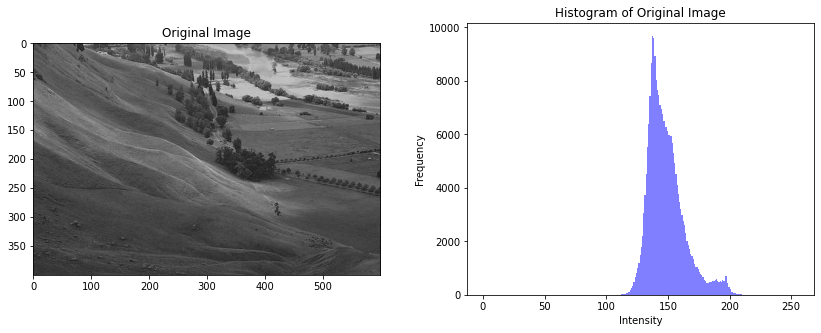

In [2]:
PATH = 'images/histogram.jpg'
img = cv2.imread(PATH, 0)


fix, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].hist(img.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.5)
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Original Image')

plt.subplots_adjust(wspace=0.25)
plt.show()

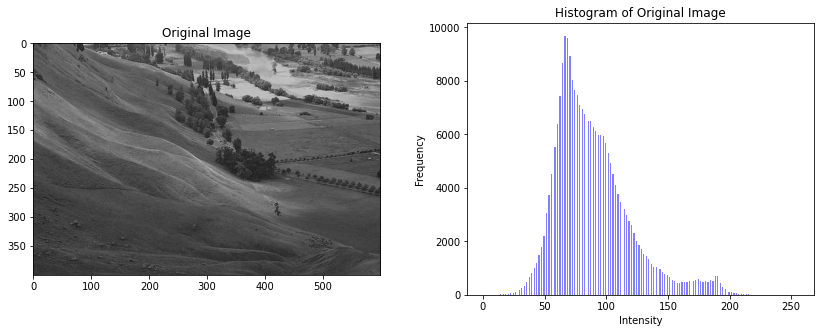

In [3]:
a_min = img.min()
a_max = img.max()
row, col = img.shape[:2]

for i in range (row):
    for j in range(col):
        img[i][j] = (((img[i][j] - a_min) / (a_max - a_min)) * 255)
img = img.astype(np.uint8)

fix, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].hist(img.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.5)
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Original Image')

plt.subplots_adjust(wspace=0.25)
plt.show()

In [4]:
def frequency_count(image: cv2.Mat):
    frequency = np.zeros((256), dtype=int)
    row, col = image.shape[:2]
    
    for i in range(row):
        for j in range(col):
            x = image[i][j]
            frequency[x] += 1
    return frequency


In [5]:
def get_cdf(pdf: npt.NDArray[np.float32]):
    cdf = np.zeros((256), dtype = float)
    rounded = np.zeros((256), dtype = int)
    cdf[0] = pdf[0]
    rounded[0] = round(cdf[0] * (256 - 1))
    
    for i in range(1, pdf.shape[0]):
        cdf[i] = cdf[i-1] + pdf[i]
        rounded[i] = round(cdf[i] * (256 - 1))
    return cdf, rounded

In [6]:
def histogram_specification(img: cv2.Mat, miu: int=208, sigma:int=50):
    row, col = img.shape[:2]
    L = 256
    # gaussian / normal distribution
    guass_func = np.random.normal(miu, sigma, size=(row, col))
    # round up and type cust to int from float
    guass_func = np.round(guass_func).astype(int)
    
    # make the range between 0-255 by thresholding
    guass_func[guass_func>255] = 255
    guass_func[guass_func<0] = 0
    
    # frequency of each intensity 
    img_freq = frequency_count(img)
    gauss_freq = frequency_count(guass_func)
    
    # image size
    img_size = row * col
    guass_size = guass_func.shape[0] * guass_func.shape[1]
    
    # PDF or normalized histogram
    img_pdf = img_freq / img_size
    gauss_pdf = gauss_freq / guass_size
    
    
    # CDF and transformation function calculation 
    img_cdf, img_rounded_cdf = get_cdf(img_pdf)  
    gauss_cdf, gauss_rounded_cdf = get_cdf(gauss_pdf) 
    
    # histogram matching
    mapped_img_one = np.zeros((L), dtype = int)
    mapped_img_two = np.zeros((L), dtype = int)
    
    for i in range(L):
        for j in range(L):
            if img_rounded_cdf[i] == gauss_rounded_cdf[j]:
                mapped_img_one[i] = j
                mapped_img_two[i] = j
                break
            elif img_rounded_cdf[i] < gauss_rounded_cdf[j]:
                prev_dis = img_rounded_cdf[i] - gauss_rounded_cdf[j-1]
                current_dis = gauss_rounded_cdf[j] - img_rounded_cdf[i]
                if current_dis < prev_dis:
                    mapped_img_one[i] = j
                    mapped_img_two[i] = j-1
                else:
                    mapped_img_one[i] = j-1
                    mapped_img_two[i] = j
                break
    
    output_one = copy.deepcopy(img)
    output_two = copy.deepcopy(img)
    
    for i in range(row):
        for j in range(col):
            output_one[i][j] = mapped_img_one[img[i][j]]
            output_two[i][j] = mapped_img_two[img[i][j]]
    
    # frequency of output image
    output_freq = frequency_count(output_one)
    # PDF or normalized histogram
    output_pdf = output_freq / img_size
    # CDF and transformation function calculation 
    _output_cdf, output_rounded_cdf = get_cdf(output_pdf)
    
    return guass_func, img_cdf, gauss_cdf, output_one, output_two, output_rounded_cdf


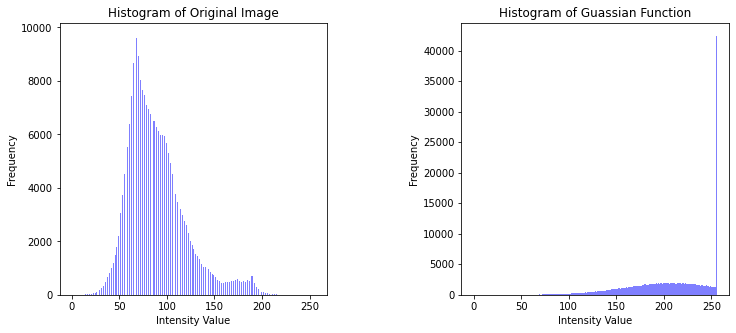

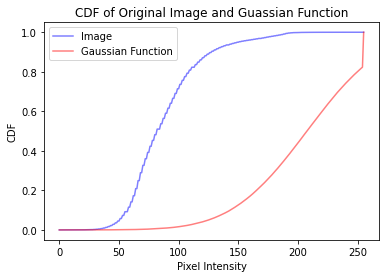

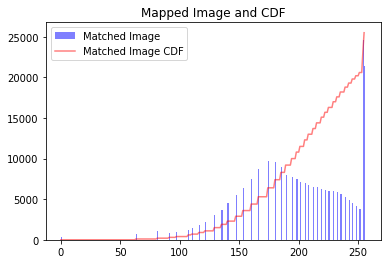

In [7]:
# histogram specification output
gauss_func, img_cdf, guass_cdf, output_one, output_two, matched_cdf = histogram_specification(img)

# plot the input historam and gaussian histogram
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(img.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.5)
ax[0].set_xlabel('Intensity Value')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Original Image')
ax[1].hist(gauss_func.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.5)
ax[1].set_xlabel('Intensity Value')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Guassian Function')

plt.subplots_adjust(wspace=0.5)
plt.show()

# plot the CDFs
plt.plot(img_cdf,color='blue', alpha=0.5, label='Image')
plt.plot(guass_cdf, color='red', alpha=0.5, label='Gaussian Function')
plt.xlabel('Pixel Intensity')
plt.ylabel('CDF')
plt.title('CDF of Original Image and Guassian Function')
plt.legend()
plt.show()

# plot the mapped input historam and matched cdf
plt.hist(output_one.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.5, label='Matched Image')
plt.plot(matched_cdf * 100, color='red', alpha=0.5, label='Matched Image CDF')
plt.legend()
plt.title('Mapped Image and CDF')
plt.show()

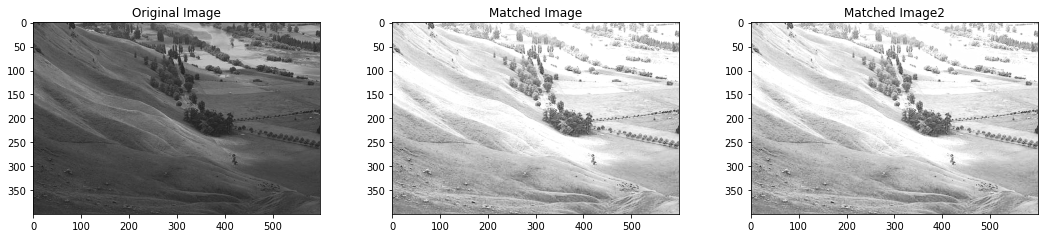

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(18, 8))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(output_one, cmap='gray')
ax[1].set_title('Matched Image')
ax[2].imshow(output_two, cmap='gray')
ax[2].set_title('Matched Image2')

plt.subplots_adjust(wspace=0.25)
plt.show()